# Predicting Home Sale Prices: A Data-Driven Approach to Real Estate Valuation

## Problem Definition


This goal of this project is to help a real estate company accurately predict house sale prices based on property features such as size, location, and age. The business goal is to improve pricing strategies and decision-making for buyers and sellers. This is a supervised regression problem, where the target variable is the numeric sale price. The  model will attempt minimize Root Mean Squared Percentage Error (RMSPE) to ensure accurate predictions.

## Data Collection/Sources


The data set contains information from the
Assessor's Office used in computing assessed values for individual
residential properties sold from 2006 to 2010.
It is hosted in an AWS S3 bucket.
https://www.google.com/url?q=https%3A%2F%2Fddc-datascience.s3.amazonaws.com%2FProjects%2FProject.2-Housing%2FData%2FHousing.Data.csv

## File Paths

In [1]:
import pandas as pd

url = "https://ddc-datascience.s3.amazonaws.com/Projects/Project.2-Housing/Data/Housing.Data.csv"


In [2]:
# Additional imports

import numpy as np         # Numerical operations
import matplotlib.pyplot as plt    # Basic plotting
import seaborn as sns              # Statistical plots
import plotly.express as px        # Interactive plots

from sklearn.model_selection import train_test_split       # Splitting data
from sklearn.preprocessing import RobustScaler           # Feature scaling

from sklearn.preprocessing import OneHotEncoder            # Categorical encoding

from sklearn.metrics import mean_squared_error, r2_score   # Basic metrics


In [3]:
# Load data
housing_df = pd.read_csv(url)
housing_df


,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,905101070,20,RL,62.0,14299,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,7,2007,WD,Normal,115400
1,905101330,90,RL,72.0,10791,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,Shed,500,10,2006,WD,Normal,90000
2,903454090,50,RM,50.0,9000,Pave,NaN,Reg,Bnk,AllPub,...,0,NaN,NaN,NaN,0,12,2007,WD,Normal,141000
3,533244030,60,FV,68.0,7379,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,254000
4,909252020,70,RL,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,4,2009,WD,Normal,155000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2632,903231070,50,RM,52.0,6240,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,400,9,2006,WD,Normal,114500
2633,906201021,80,RL,74.0,10778,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2009,WD,Normal,162000
2634,533253070,120,RL,61.0,3782,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2009,WD,Normal,211500
2635,527376100,20,RL,78.0,10140,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,8,2009,WD,Normal,165000


## Data Cleaning


### Backup 1

In [4]:
# Initial backup copy of the data frame

housing_df_bak1 = housing_df.copy()
housing_df_bak1


,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,905101070,20,RL,62.0,14299,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,7,2007,WD,Normal,115400
1,905101330,90,RL,72.0,10791,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,Shed,500,10,2006,WD,Normal,90000
2,903454090,50,RM,50.0,9000,Pave,NaN,Reg,Bnk,AllPub,...,0,NaN,NaN,NaN,0,12,2007,WD,Normal,141000
3,533244030,60,FV,68.0,7379,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,254000
4,909252020,70,RL,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,4,2009,WD,Normal,155000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2632,903231070,50,RM,52.0,6240,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,400,9,2006,WD,Normal,114500
2633,906201021,80,RL,74.0,10778,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2009,WD,Normal,162000
2634,533253070,120,RL,61.0,3782,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2009,WD,Normal,211500
2635,527376100,20,RL,78.0,10140,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,8,2009,WD,Normal,165000


In [5]:
housing_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2637 entries, 0 to 2636
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PID              2637 non-null   int64  
 1   MS SubClass      2637 non-null   int64  
 2   MS Zoning        2637 non-null   object 
 3   Lot Frontage     2188 non-null   float64
 4   Lot Area         2637 non-null   int64  
 5   Street           2637 non-null   object 
 6   Alley            180 non-null    object 
 7   Lot Shape        2637 non-null   object 
 8   Land Contour     2637 non-null   object 
 9   Utilities        2637 non-null   object 
 10  Lot Config       2637 non-null   object 
 11  Land Slope       2637 non-null   object 
 12  Neighborhood     2637 non-null   object 
 13  Condition 1      2637 non-null   object 
 14  Condition 2      2637 non-null   object 
 15  Bldg Type        2637 non-null   object 
 16  House Style      2637 non-null   object 
 17  Overall Qual  

In [6]:
housing_df.describe()


,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
count,2.637000e+03,2637.000000,2188.000000,2637.000000,2637.000000,2637.000000,2637.000000,2637.000000,2614.000000,2636.000000,...,2637.000000,2637.000000,2637.000000,2637.000000,2637.000000,2637.000000,2637.000000,2637.000000,2637.000000,2637.000000
mean,7.141301e+08,57.349261,69.166819,10044.694729,6.097459,5.569966,1971.288586,1984.202882,101.887911,438.441199,...,94.305271,46.984452,22.813424,2.368601,15.775123,2.130072,42.014031,6.243838,2007.795601,179986.230186
std,1.887527e+08,42.499091,23.356779,6742.549521,1.411522,1.118262,30.306986,20.913077,179.578232,449.602326,...,126.927272,66.564333,61.177638,23.160600,55.783751,35.140140,393.158781,2.722093,1.306403,78309.251522
min,5.263011e+08,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,5.284770e+08,20.000000,58.000000,7436.000000,5.000000,5.000000,1954.000000,1965.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129500.000000
50%,5.354530e+08,50.000000,68.000000,9450.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.000000,...,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,160000.000000
75%,9.071870e+08,70.000000,80.000000,11526.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,732.000000,...,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,213000.000000
max,1.007100e+09,190.000000,313.000000,164660.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,1424.000000,742.000000,584.000000,407.000000,576.000000,800.000000,12500.000000,12.000000,2010.000000,745000.000000


In [7]:
housing_df.shape


(2637, 81)

In [8]:
housing_df.size


213597

In [9]:
housing_df.head(5)


,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,905101070,20,RL,62.0,14299,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,7,2007,WD,Normal,115400
1,905101330,90,RL,72.0,10791,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,Shed,500,10,2006,WD,Normal,90000
2,903454090,50,RM,50.0,9000,Pave,NaN,Reg,Bnk,AllPub,...,0,NaN,NaN,NaN,0,12,2007,WD,Normal,141000
3,533244030,60,FV,68.0,7379,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,254000
4,909252020,70,RL,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,4,2009,WD,Normal,155000


In [10]:
housing_df.tail(5)


,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
2632,903231070,50,RM,52.0,6240,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,400,9,2006,WD,Normal,114500
2633,906201021,80,RL,74.0,10778,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2009,WD,Normal,162000
2634,533253070,120,RL,61.0,3782,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2009,WD,Normal,211500
2635,527376100,20,RL,78.0,10140,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,8,2009,WD,Normal,165000
2636,528292060,60,RL,41.0,12460,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2008,WD,Normal,225000


In [11]:
# View null values

housing_df.isna().sum()


,0
PID,0
MS SubClass,0
MS Zoning,0
Lot Frontage,449
Lot Area,0
...,...
Mo Sold,0
Yr Sold,0
Sale Type,0
Sale Condition,0


In [12]:
# Count the number of distinct elements in rows

housing_df.nunique().sort_values(ascending = False).head(20)


,0
PID,2637
Lot Area,1799
Gr Liv Area,1216
Bsmt Unf SF,1080
1st Flr SF,1022
Total Bsmt SF,1001
SalePrice,983
BsmtFin SF 1,935
2nd Flr SF,589
Garage Area,576


In [13]:
housing_df.nunique().sort_values(ascending = False).tail(20)


,0
Land Contour,4
Lot Shape,4
Fence,4
Pool QC,4
Misc Feature,4
Kitchen AbvGr,4
Kitchen Qual,4
Bsmt Exposure,4
Exter Qual,4
Mas Vnr Type,4


In [14]:
# Check if there are null series

housing_df.isnull().all()


,0
PID,False
MS SubClass,False
MS Zoning,False
Lot Frontage,False
Lot Area,False
...,...
Mo Sold,False
Yr Sold,False
Sale Type,False
Sale Condition,False


In [15]:
# Count nulls per column, sort descending

column_nulls = housing_df.isnull().sum().sort_values(ascending=False)

column_nulls


,0
Pool QC,2626
Misc Feature,2541
Alley,2457
Fence,2109
Mas Vnr Type,1607
...,...
Mo Sold,0
Yr Sold,0
Sale Type,0
Sale Condition,0


In [16]:
column_nulls[column_nulls > 0]


,0
Pool QC,2626
Misc Feature,2541
Alley,2457
Fence,2109
Mas Vnr Type,1607
Fireplace Qu,1284
Lot Frontage,449
Garage Yr Blt,147
Garage Cond,147
Garage Qual,147


In [17]:
# Drop data series that have null values > ~ 1/3

drop = column_nulls[column_nulls > 880]
drop


,0
Pool QC,2626
Misc Feature,2541
Alley,2457
Fence,2109
Mas Vnr Type,1607
Fireplace Qu,1284


In [18]:
# Drop unecessary and low-value data series

housing_df.drop(columns=list(drop.index) + ['PID'], inplace=True)


In [19]:
# Check remaining number of columns
housing_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2637 entries, 0 to 2636
Data columns (total 74 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MS SubClass      2637 non-null   int64  
 1   MS Zoning        2637 non-null   object 
 2   Lot Frontage     2188 non-null   float64
 3   Lot Area         2637 non-null   int64  
 4   Street           2637 non-null   object 
 5   Lot Shape        2637 non-null   object 
 6   Land Contour     2637 non-null   object 
 7   Utilities        2637 non-null   object 
 8   Lot Config       2637 non-null   object 
 9   Land Slope       2637 non-null   object 
 10  Neighborhood     2637 non-null   object 
 11  Condition 1      2637 non-null   object 
 12  Condition 2      2637 non-null   object 
 13  Bldg Type        2637 non-null   object 
 14  House Style      2637 non-null   object 
 15  Overall Qual     2637 non-null   int64  
 16  Overall Cond     2637 non-null   int64  
 17  Year Built    

In [20]:
# Check for rows with null values in the 'SalePrice' field

housing_df['SalePrice'].isna()


,SalePrice
0,False
1,False
2,False
3,False
4,False
...,...
2632,False
2633,False
2634,False
2635,False


In [21]:
# Check for rows with >= 10% null values

row_nulls = housing_df[housing_df.isnull().sum(axis=1) >= 7]
row_nulls

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,...,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
52,20,RL,77.0,8335,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,190,0,0,0,0,4,2006,WD,Normal,93000
421,90,RL,65.0,6040,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,6,2008,WD,AdjLand,82000
526,50,RL,57.0,8050,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,4,2008,WD,Normal,96000
761,90,RL,74.0,6845,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,7,2008,WD,Normal,82500
847,20,RM,99.0,5940,Pave,IR1,Lvl,AllPub,FR3,Gtl,...,0,0,0,0,0,4,2008,ConLD,Abnorml,79000
944,190,RM,70.0,5600,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,3500,7,2010,WD,Normal,55000
969,20,RL,123.0,47007,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,7,2008,WD,Normal,284700
1143,50,RM,52.0,6240,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,7,2006,WD,Normal,80500
1525,20,RL,50.0,5000,Pave,Reg,Low,AllPub,Inside,Mod,...,0,0,0,0,0,1,2007,WD,Normal,39300
1588,90,RL,75.0,9825,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,5,2010,WD,Normal,100000


In [22]:
# Drop rows with >= 7 missing values

housing_df.drop(index=row_nulls.index, inplace=True)


In [23]:
housing_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2622 entries, 0 to 2636
Data columns (total 74 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MS SubClass      2622 non-null   int64  
 1   MS Zoning        2622 non-null   object 
 2   Lot Frontage     2173 non-null   float64
 3   Lot Area         2622 non-null   int64  
 4   Street           2622 non-null   object 
 5   Lot Shape        2622 non-null   object 
 6   Land Contour     2622 non-null   object 
 7   Utilities        2622 non-null   object 
 8   Lot Config       2622 non-null   object 
 9   Land Slope       2622 non-null   object 
 10  Neighborhood     2622 non-null   object 
 11  Condition 1      2622 non-null   object 
 12  Condition 2      2622 non-null   object 
 13  Bldg Type        2622 non-null   object 
 14  House Style      2622 non-null   object 
 15  Overall Qual     2622 non-null   int64  
 16  Overall Cond     2622 non-null   int64  
 17  Year Built       26

In [24]:
housing_df.isna().sum().sort_values(ascending=False).head(20)


,0
Lot Frontage,449
Garage Qual,134
Garage Yr Blt,134
Garage Finish,134
Garage Cond,134
Garage Type,132
Bsmt Exposure,61
BsmtFin Type 2,59
Bsmt Qual,58
BsmtFin Type 1,58


### Make backup 2

In [25]:
# Make backup 2

housing_df_lowNaN = housing_df.copy()
housing_df_lowNaN


,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,...,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,20,RL,62.0,14299,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,7,2007,WD,Normal,115400
1,90,RL,72.0,10791,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,500,10,2006,WD,Normal,90000
2,50,RM,50.0,9000,Pave,Reg,Bnk,AllPub,Inside,Gtl,...,0,0,126,0,0,12,2007,WD,Normal,141000
3,60,FV,68.0,7379,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,4,2010,WD,Normal,254000
4,70,RL,60.0,7200,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,4,2009,WD,Normal,155000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2632,50,RM,52.0,6240,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,400,9,2006,WD,Normal,114500
2633,80,RL,74.0,10778,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,7,2009,WD,Normal,162000
2634,120,RL,61.0,3782,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,...,0,0,0,0,0,9,2009,WD,Normal,211500
2635,20,RL,78.0,10140,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,8,2009,WD,Normal,165000


### Keep only numeric series

In [26]:
# Identify numeric series

housing_numeric_series_df = housing_df_lowNaN.select_dtypes(include='number')
housing_numeric_series_df


,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
0,20,62.0,14299,4,3,1964,1964,0.0,513.0,144.0,...,0,0,0,0,0,0,0,7,2007,115400
1,90,72.0,10791,4,5,1967,1967,0.0,0.0,0.0,...,0,0,0,0,0,0,500,10,2006,90000
2,50,50.0,9000,6,6,1937,1950,0.0,0.0,0.0,...,0,162,0,0,126,0,0,12,2007,141000
3,60,68.0,7379,8,5,2000,2000,0.0,484.0,0.0,...,280,184,0,0,0,0,0,4,2010,254000
4,70,60.0,7200,7,9,1936,2007,0.0,350.0,210.0,...,256,0,0,0,0,0,0,4,2009,155000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2632,50,52.0,6240,6,6,1934,1950,0.0,0.0,0.0,...,112,0,0,0,0,0,400,9,2006,114500
2633,80,74.0,10778,7,6,1990,1991,0.0,460.0,286.0,...,114,36,0,0,0,0,0,7,2009,162000
2634,120,61.0,3782,8,5,1981,1981,0.0,960.0,0.0,...,133,78,0,0,0,0,0,9,2009,211500
2635,20,78.0,10140,6,5,1974,1974,174.0,0.0,0.0,...,0,0,0,0,0,0,0,8,2009,165000


In [27]:
# Establish drop thresholds for series with significant zero values
zero_threshold = 0.55   # Drop if 55%+ values are zero

# Establish drop thresholds for series with low abs correlation with SalesPrice
corr_threshold = 0.45 #Drop if abs(correlation with SalesPrice) =<45%

# Calculate percent of zeros
zero_fraction = (housing_numeric_series_df == 0).sum() / len(housing_numeric_series_df)

# Correlation with target
correlations = housing_numeric_series_df.corr()['SalePrice'].abs()

# Identify series to drop
drop_numeric_series = zero_fraction[(zero_fraction > zero_threshold) & (correlations < corr_threshold)].index.tolist()
drop_numeric_series


['BsmtFin SF 2',
 '2nd Flr SF',
 'Low Qual Fin SF',
 'Bsmt Full Bath',
 'Bsmt Half Bath',
 'Half Bath',
 'Enclosed Porch',
 '3Ssn Porch',
 'Screen Porch',
 'Pool Area',
 'Misc Val']

In [28]:
# Drop series that have significant zero values and and low abs correlation with SalesPrice

housing_numeric_series_df.drop(columns=drop_numeric_series , inplace=True)
housing_numeric_series_df


,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,Bsmt Unf SF,...,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Mo Sold,Yr Sold,SalePrice
0,20,62.0,14299,4,3,1964,1964,0.0,513.0,348.0,...,5,0,1964.0,2.0,440.0,0,0,7,2007,115400
1,90,72.0,10791,4,5,1967,1967,0.0,0.0,0.0,...,6,0,1967.0,2.0,516.0,0,0,10,2006,90000
2,50,50.0,9000,6,6,1937,1950,0.0,0.0,780.0,...,6,1,1979.0,1.0,544.0,0,162,12,2007,141000
3,60,68.0,7379,8,5,2000,2000,0.0,484.0,491.0,...,7,1,2000.0,2.0,592.0,280,184,4,2010,254000
4,70,60.0,7200,7,9,1936,2007,0.0,350.0,0.0,...,6,0,1971.0,2.0,576.0,256,0,4,2009,155000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2632,50,52.0,6240,6,6,1934,1950,0.0,0.0,816.0,...,6,1,1985.0,2.0,528.0,112,0,9,2006,114500
2633,80,74.0,10778,7,6,1990,1991,0.0,460.0,308.0,...,4,0,1990.0,2.0,462.0,114,36,7,2009,162000
2634,120,61.0,3782,8,5,1981,1981,0.0,960.0,266.0,...,4,2,1981.0,2.0,484.0,133,78,9,2009,211500
2635,20,78.0,10140,6,5,1974,1974,174.0,0.0,1064.0,...,7,1,1974.0,2.0,478.0,0,0,8,2009,165000


In [29]:
# Look for numeric series correlated with each other & != target

# Compute feature correlation matrix
corr_matrix = housing_numeric_series_df.corr().abs()

# Get features' correlation with target
target_col = 'SalePrice'

# Make a list of correlated feature pairs
corr_threshold = 0.75

corr_pairs = [
  (col1, col2 , corr_matrix.loc[col1, col2])
  for col1 in corr_matrix.columns
  for col2 in corr_matrix.columns
  if col1 != col2
  and col1 != target_col
  and col2 != target_col
  and corr_matrix.loc[col1, col2] > corr_threshold
]

corr_pairs


[('Year Built', 'Garage Yr Blt', np.float64(0.8316455991777784)),
 ('Total Bsmt SF', '1st Flr SF', np.float64(0.8043262223833144)),
 ('1st Flr SF', 'Total Bsmt SF', np.float64(0.8043262223833144)),
 ('Gr Liv Area', 'TotRms AbvGrd', np.float64(0.8063914090036697)),
 ('TotRms AbvGrd', 'Gr Liv Area', np.float64(0.8063914090036697)),
 ('Garage Yr Blt', 'Year Built', np.float64(0.8316455991777784)),
 ('Garage Cars', 'Garage Area', np.float64(0.8892293379210543)),
 ('Garage Area', 'Garage Cars', np.float64(0.8892293379210543))]

In [30]:
#  Get correlation of all features with SalePrice
target_corr = corr_matrix[target_col]
target_corr


,SalePrice
MS SubClass,0.076185
Lot Frontage,0.357954
Lot Area,0.266115
Overall Qual,0.804576
Overall Cond,0.099644
Year Built,0.561657
Year Remod/Add,0.536693
Mas Vnr Area,0.506336
BsmtFin SF 1,0.425327
Bsmt Unf SF,0.168996


In [31]:
# Drop features less correlated with SalePrice

drop_features = set()

for col1, col2, corr_val in corr_pairs:
    if col1 in drop_features or col2 in drop_features:
        continue  # skip already selected for drop to avoid overlapping pairs
    if target_corr[col1] < target_corr[col2]:
        drop_features.add(col1)
    else:
        drop_features.add(col2)

# Then drop them from the DataFrame
housing_numeric_series_df.drop(columns=drop_features, inplace=True)


In [32]:
housing_numeric_series_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2622 entries, 0 to 2636
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   MS SubClass     2622 non-null   int64  
 1   Lot Frontage    2173 non-null   float64
 2   Lot Area        2622 non-null   int64  
 3   Overall Qual    2622 non-null   int64  
 4   Overall Cond    2622 non-null   int64  
 5   Year Built      2622 non-null   int64  
 6   Year Remod/Add  2622 non-null   int64  
 7   Mas Vnr Area    2599 non-null   float64
 8   BsmtFin SF 1    2622 non-null   float64
 9   Bsmt Unf SF     2622 non-null   float64
 10  Total Bsmt SF   2622 non-null   float64
 11  Gr Liv Area     2622 non-null   int64  
 12  Full Bath       2622 non-null   int64  
 13  Bedroom AbvGr   2622 non-null   int64  
 14  Kitchen AbvGr   2622 non-null   int64  
 15  Fireplaces      2622 non-null   int64  
 16  Garage Cars     2621 non-null   float64
 17  Wood Deck SF    2622 non-null   int64 

In [33]:
# Check if numeric dtypes series are continuous, nominal, or ordinal categorical in data dictionary:
# https://ddc-datascience.s3.amazonaws.com/Projects/Project.2-Housing/Housing%20-%20Data%20Documentation.pdf
drop_noncontinuous = ['MS SubClass','Overall Qual','Overall Cond','Mo Sold']

# Drop non-continuous series
housing_numeric_series_df.drop(columns = drop_noncontinuous, inplace=True)
housing_numeric_series_df


,Lot Frontage,Lot Area,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,Bsmt Unf SF,Total Bsmt SF,Gr Liv Area,Full Bath,Bedroom AbvGr,Kitchen AbvGr,Fireplaces,Garage Cars,Wood Deck SF,Open Porch SF,Yr Sold,SalePrice
0,62.0,14299,1964,1964,0.0,513.0,348.0,1005.0,1005,1,3,1,0,2.0,0,0,2007,115400
1,72.0,10791,1967,1967,0.0,0.0,0.0,0.0,1296,2,2,2,0,2.0,0,0,2006,90000
2,50.0,9000,1937,1950,0.0,0.0,780.0,780.0,1375,1,3,1,1,1.0,0,162,2007,141000
3,68.0,7379,2000,2000,0.0,484.0,491.0,975.0,1848,2,3,1,1,2.0,280,184,2010,254000
4,60.0,7200,1936,2007,0.0,350.0,0.0,560.0,1135,1,3,1,0,2.0,256,0,2009,155000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2632,52.0,6240,1934,1950,0.0,0.0,816.0,816.0,1176,1,3,1,1,2.0,112,0,2006,114500
2633,74.0,10778,1990,1991,0.0,460.0,308.0,1054.0,1061,1,1,1,0,2.0,114,36,2009,162000
2634,61.0,3782,1981,1981,0.0,960.0,266.0,1226.0,1226,1,1,1,2,2.0,133,78,2009,211500
2635,78.0,10140,1974,1974,174.0,0.0,1064.0,1064.0,1350,2,3,1,1,2.0,0,0,2009,165000


In [34]:
housing_numeric_series_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2622 entries, 0 to 2636
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Lot Frontage    2173 non-null   float64
 1   Lot Area        2622 non-null   int64  
 2   Year Built      2622 non-null   int64  
 3   Year Remod/Add  2622 non-null   int64  
 4   Mas Vnr Area    2599 non-null   float64
 5   BsmtFin SF 1    2622 non-null   float64
 6   Bsmt Unf SF     2622 non-null   float64
 7   Total Bsmt SF   2622 non-null   float64
 8   Gr Liv Area     2622 non-null   int64  
 9   Full Bath       2622 non-null   int64  
 10  Bedroom AbvGr   2622 non-null   int64  
 11  Kitchen AbvGr   2622 non-null   int64  
 12  Fireplaces      2622 non-null   int64  
 13  Garage Cars     2621 non-null   float64
 14  Wood Deck SF    2622 non-null   int64  
 15  Open Porch SF   2622 non-null   int64  
 16  Yr Sold         2622 non-null   int64  
 17  SalePrice       2622 non-null   int64 

In [35]:
# Strip SalePrice (target var) and Yr Sold (possibly a numeric categorical) from data frame

housing_numeric_series_df.drop(columns=['Yr Sold'], inplace=True)
housing_numeric_series_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2622 entries, 0 to 2636
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Lot Frontage    2173 non-null   float64
 1   Lot Area        2622 non-null   int64  
 2   Year Built      2622 non-null   int64  
 3   Year Remod/Add  2622 non-null   int64  
 4   Mas Vnr Area    2599 non-null   float64
 5   BsmtFin SF 1    2622 non-null   float64
 6   Bsmt Unf SF     2622 non-null   float64
 7   Total Bsmt SF   2622 non-null   float64
 8   Gr Liv Area     2622 non-null   int64  
 9   Full Bath       2622 non-null   int64  
 10  Bedroom AbvGr   2622 non-null   int64  
 11  Kitchen AbvGr   2622 non-null   int64  
 12  Fireplaces      2622 non-null   int64  
 13  Garage Cars     2621 non-null   float64
 14  Wood Deck SF    2622 non-null   int64  
 15  Open Porch SF   2622 non-null   int64  
 16  SalePrice       2622 non-null   int64  
dtypes: float64(6), int64(11)
memory usage:

### Encode 'object' categorical series

In [36]:
# These are the numeric categoricals identified in the numeric datatype series

numeric_categoricals = ['MS SubClass','Mo Sold','Yr Sold']

In [37]:
# Select datatype 'object' series from DataFrame
categorical_obj = housing_df_lowNaN.select_dtypes(include='object')


# Build a summary DataFrame for 'object' data
obj_summary = pd.DataFrame({
    'column': categorical_obj.columns,
    'n_unique': [housing_df_lowNaN[col].nunique() for col in categorical_obj.columns]
})

# Sort summary DataFrame by number of unique values
obj_summary.sort_values(by='n_unique', ascending=True, inplace=True)

# Show
obj_summary.reset_index(drop=True, inplace=True)
obj_summary


,column,n_unique
0,Street,2
1,Central Air,2
2,Land Slope,3
3,Utilities,3
4,Garage Finish,3
5,Paved Drive,3
6,Land Contour,4
7,Exter Qual,4
8,Bsmt Exposure,4
9,Kitchen Qual,4


In [38]:
# Put categorical object columns in a list

categorical_obj = housing_df_lowNaN.select_dtypes(include='object').columns.tolist()

# Print unique values for each
for col in categorical_obj:
    print(f"{col} ({housing_df_lowNaN[col].nunique()} unique values):")
    print(housing_df_lowNaN[col].unique())
    print('-' * 15)


MS Zoning (7 unique values):
['RL' 'RM' 'FV' 'C (all)' 'RH' 'I (all)' 'A (agr)']
---------------
Street (2 unique values):
['Pave' 'Grvl']
---------------
Lot Shape (4 unique values):
['Reg' 'IR1' 'IR2' 'IR3']
---------------
Land Contour (4 unique values):
['Lvl' 'Bnk' 'HLS' 'Low']
---------------
Utilities (3 unique values):
['AllPub' 'NoSewr' 'NoSeWa']
---------------
Lot Config (5 unique values):
['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
---------------
Land Slope (3 unique values):
['Gtl' 'Mod' 'Sev']
---------------
Neighborhood (28 unique values):
['Sawyer' 'IDOTRR' 'Somerst' 'SWISU' 'CollgCr' 'Edwards' 'OldTown'
 'Mitchel' 'NridgHt' 'ClearCr' 'NWAmes' 'Gilbert' 'NoRidge' 'NAmes'
 'Timber' 'MeadowV' 'StoneBr' 'Blmngtn' 'SawyerW' 'Crawfor' 'Veenker'
 'BrkSide' 'GrnHill' 'BrDale' 'NPkVill' 'Greens' 'Blueste' 'Landmrk']
---------------
Condition 1 (9 unique values):
['Feedr' 'Norm' 'PosA' 'RRAn' 'PosN' 'Artery' 'RRNn' 'RRAe' 'RRNe']
---------------
Condition 2 (8 unique values):
['

In [39]:
# Check if numeric dtypes series are nominal or ordinal categorical in data dictionary:
# https://ddc-datascience.s3.amazonaws.com/Projects/Project.2-Housing/Housing%20-%20Data%20Documentation.pdf

# Make ordinal series list

obj_ordinal_series = ['Overall Qual','Overall Cond','Land Slope','Lot Shape','Utilities','Exter Qual',
                  'Exter Cond','Bsmt Qual','Bsmt Cond','Bsmt Exposure','BsmtFin Type 1','BsmtFin Type 2',
                  'Heating QC','Electrical','Kitchen Qual','Garage Finish','Garage Qual','Garage Cond','Paved Drive']
obj_ordinal_series


['Overall Qual',
 'Overall Cond',
 'Land Slope',
 'Lot Shape',
 'Utilities',
 'Exter Qual',
 'Exter Cond',
 'Bsmt Qual',
 'Bsmt Cond',
 'Bsmt Exposure',
 'BsmtFin Type 1',
 'BsmtFin Type 2',
 'Heating QC',
 'Electrical',
 'Kitchen Qual',
 'Garage Finish',
 'Garage Qual',
 'Garage Cond',
 'Paved Drive']

In [40]:
# Make nominal series list

obj_nominal_series = obj_nominal_series = [col for col in categorical_obj if col not in obj_ordinal_series]
obj_nominal_series


['MS Zoning',
 'Street',
 'Land Contour',
 'Lot Config',
 'Neighborhood',
 'Condition 1',
 'Condition 2',
 'Bldg Type',
 'House Style',
 'Roof Style',
 'Roof Matl',
 'Exterior 1st',
 'Exterior 2nd',
 'Foundation',
 'Heating',
 'Central Air',
 'Functional',
 'Garage Type',
 'Sale Type',
 'Sale Condition']

### Plan for adding 'object' categorical series to prediction models

* One-hot encode nominal series and correlate with target series;
* Drop nominal series uncorrelated with target;
* Encode ord series as ordered numbers;
* Drop ord series uncorrelated with target;
* Concat numeric / nom / ord categorical series --> make all features DataFrame for train-test sets and model prediction






## Exploratory Data Analysis


### Independence of features & correlation

### Backup 3

In [41]:
# Make simple var backup for numeric series EDA

housing_numeric_series_df_bak = housing_numeric_series_df.copy()
housing_df_eda1 = housing_numeric_series_df.copy()
housing_df_eda1


,Lot Frontage,Lot Area,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,Bsmt Unf SF,Total Bsmt SF,Gr Liv Area,Full Bath,Bedroom AbvGr,Kitchen AbvGr,Fireplaces,Garage Cars,Wood Deck SF,Open Porch SF,SalePrice
0,62.0,14299,1964,1964,0.0,513.0,348.0,1005.0,1005,1,3,1,0,2.0,0,0,115400
1,72.0,10791,1967,1967,0.0,0.0,0.0,0.0,1296,2,2,2,0,2.0,0,0,90000
2,50.0,9000,1937,1950,0.0,0.0,780.0,780.0,1375,1,3,1,1,1.0,0,162,141000
3,68.0,7379,2000,2000,0.0,484.0,491.0,975.0,1848,2,3,1,1,2.0,280,184,254000
4,60.0,7200,1936,2007,0.0,350.0,0.0,560.0,1135,1,3,1,0,2.0,256,0,155000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2632,52.0,6240,1934,1950,0.0,0.0,816.0,816.0,1176,1,3,1,1,2.0,112,0,114500
2633,74.0,10778,1990,1991,0.0,460.0,308.0,1054.0,1061,1,1,1,0,2.0,114,36,162000
2634,61.0,3782,1981,1981,0.0,960.0,266.0,1226.0,1226,1,1,1,2,2.0,133,78,211500
2635,78.0,10140,1974,1974,174.0,0.0,1064.0,1064.0,1350,2,3,1,1,2.0,0,0,165000


In [42]:
# Check for skewness of numeric data series prior to scaling

skewed_vars = [
    col for col in housing_df_eda1.select_dtypes(include='number').columns
    if abs(housing_df_eda1[col].skew()) > 0.05
]
skewed_vars

['Lot Frontage',
 'Lot Area',
 'Year Built',
 'Year Remod/Add',
 'Mas Vnr Area',
 'BsmtFin SF 1',
 'Bsmt Unf SF',
 'Total Bsmt SF',
 'Gr Liv Area',
 'Full Bath',
 'Bedroom AbvGr',
 'Kitchen AbvGr',
 'Fireplaces',
 'Garage Cars',
 'Wood Deck SF',
 'Open Porch SF',
 'SalePrice']

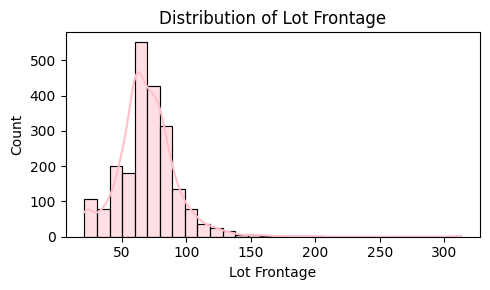

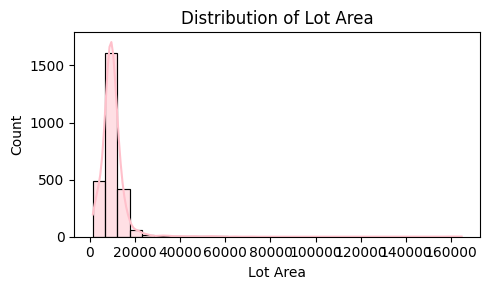

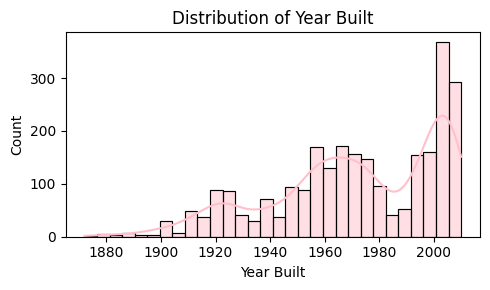

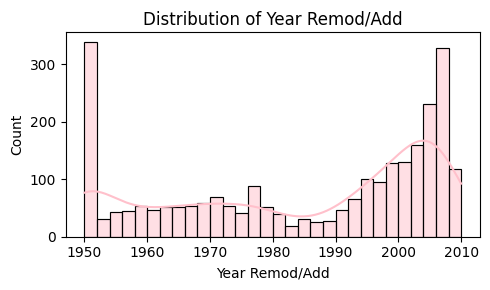

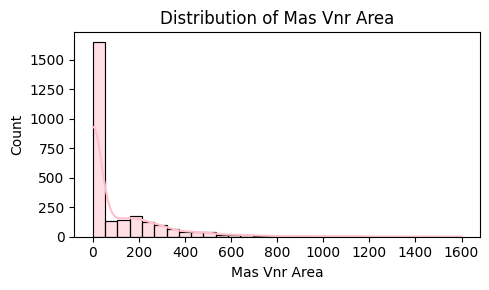

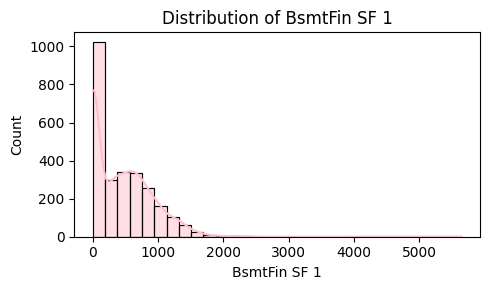

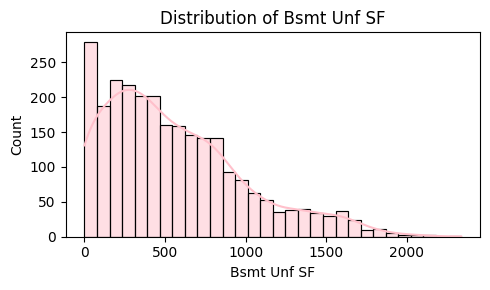

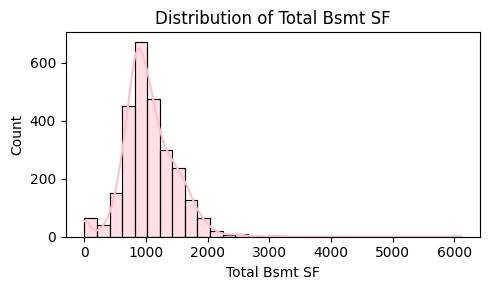

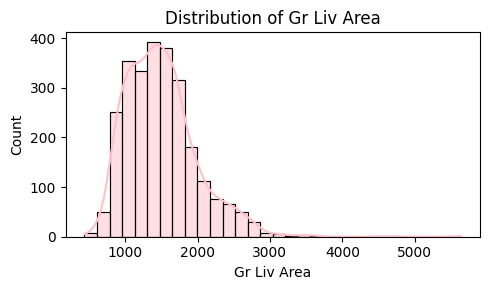

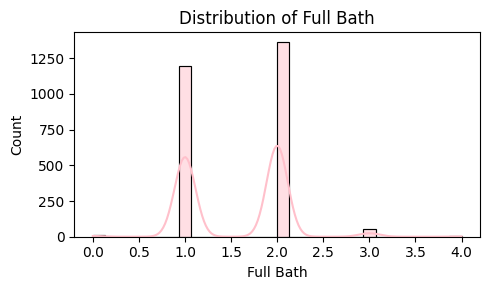

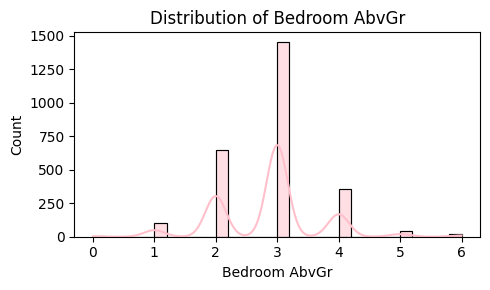

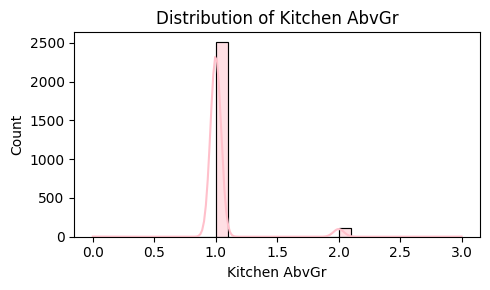

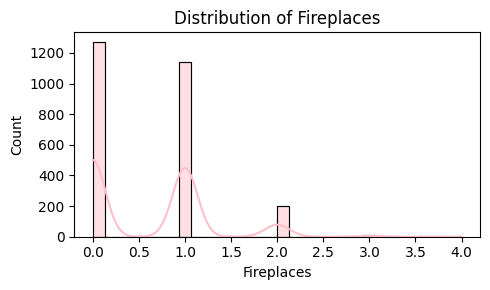

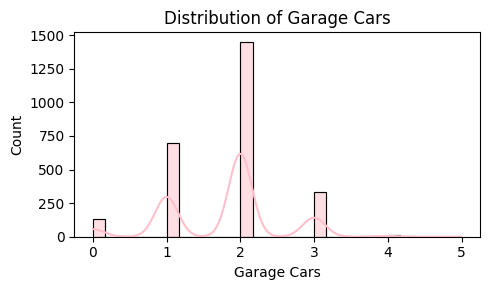

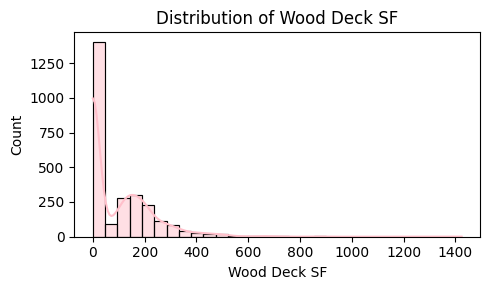

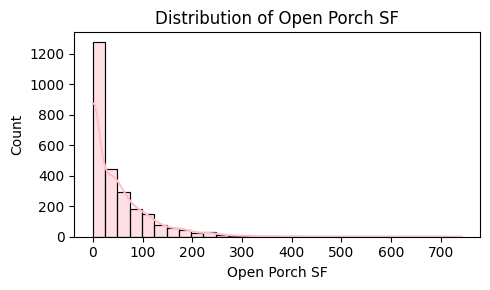

In [43]:
# Visually inspect numeric data series using KDE

# Select only numeric columns (exclude 'SalePrice')
numeric_cols = housing_df_eda1.select_dtypes(include='number').columns.drop('SalePrice', errors='ignore')

for col in numeric_cols:
    plt.figure(figsize=(5, 3))
    sns.histplot(data=housing_df_eda1, x=col, kde=True, bins=30, color='pink')
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()


## Processing



### Scale numeric series

In [44]:
# Set X (features) and y (target) values

X = housing_numeric_series_df.drop(columns='SalePrice')
y = housing_numeric_series_df['SalePrice']
X, y


(      Lot Frontage  Lot Area  Year Built  Year Remod/Add  Mas Vnr Area  \
 0             62.0     14299        1964            1964           0.0   
 1             72.0     10791        1967            1967           0.0   
 2             50.0      9000        1937            1950           0.0   
 3             68.0      7379        2000            2000           0.0   
 4             60.0      7200        1936            2007           0.0   
 ...            ...       ...         ...             ...           ...   
 2632          52.0      6240        1934            1950           0.0   
 2633          74.0     10778        1990            1991           0.0   
 2634          61.0      3782        1981            1981           0.0   
 2635          78.0     10140        1974            1974         174.0   
 2636          41.0     12460        1999            2000           0.0   
 
       BsmtFin SF 1  Bsmt Unf SF  Total Bsmt SF  Gr Liv Area  Full Bath  \
 0            513.0    

In [45]:
# Set train/test split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)
X_train, X_test, y_train, y_test


(      Lot Frontage  Lot Area  Year Built  Year Remod/Add  Mas Vnr Area  \
 2194          63.0      8199        2005            2005           0.0   
 442            NaN     12735        1972            1972           0.0   
 479           63.0     17423        2008            2009         748.0   
 2379          24.0      2304        1978            1978           0.0   
 2214          78.0      9316        2005            2005         140.0   
 ...            ...       ...         ...             ...           ...   
 1741          70.0      7700        1966            1966         351.0   
 767           64.0      7301        2003            2003         500.0   
 839           70.0     10500        1971            2005          82.0   
 1663           NaN     11454        1995            1995         302.0   
 2622          75.0      9317        1993            1993         137.0   
 
       BsmtFin SF 1  Bsmt Unf SF  Total Bsmt SF  Gr Liv Area  Full Bath  \
 2194         648.0    

In [46]:
# Fit the scaler on training data only

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled_array = X_train_scaled
X_train_scaled_array

array([[-0.26190476, -0.31490502,  0.65957447, ...,  0.        ,
         0.21428571, -0.14492754],
       [        nan,  0.78981978, -0.04255319, ...,  0.        ,
         1.28571429, -0.4057971 ],
       [-0.26190476,  1.93156357,  0.72340426, ...,  1.        ,
         0.        ,  0.46376812],
       ...,
       [ 0.07142857,  0.2454944 , -0.06382979, ..., -1.        ,
         0.20833333, -0.4057971 ],
       [        nan,  0.47783731,  0.44680851, ...,  1.        ,
         1.        ,  0.20289855],
       [ 0.30952381, -0.04262056,  0.40425532, ...,  0.        ,
         1.39285714,  0.63768116]])

In [47]:
# Use the fitted scaler to transform test data

X_test_scaled = scaler.transform(X_test)
X_test_scaled_array = X_test_scaled
X_test_scaled_array


array([[ 0.35714286,  0.45372625, -0.34042553, ...,  0.        ,
         0.        ,  4.        ],
       [-0.4047619 ,  0.23088164, -1.4893617 , ...,  0.        ,
         0.41666667,  0.72463768],
       [        nan,  2.13906478, -0.25531915, ...,  0.        ,
         3.0952381 ,  1.07246377],
       ...,
       [-0.83333333, -1.45932781, -0.61702128, ..., -2.        ,
         0.        , -0.10144928],
       [        nan,  0.78908914,  0.        , ...,  0.        ,
         1.76785714,  0.17391304],
       [ 1.97619048,  1.15294691,  0.68085106, ...,  1.        ,
         1.875     ,  0.24637681]])

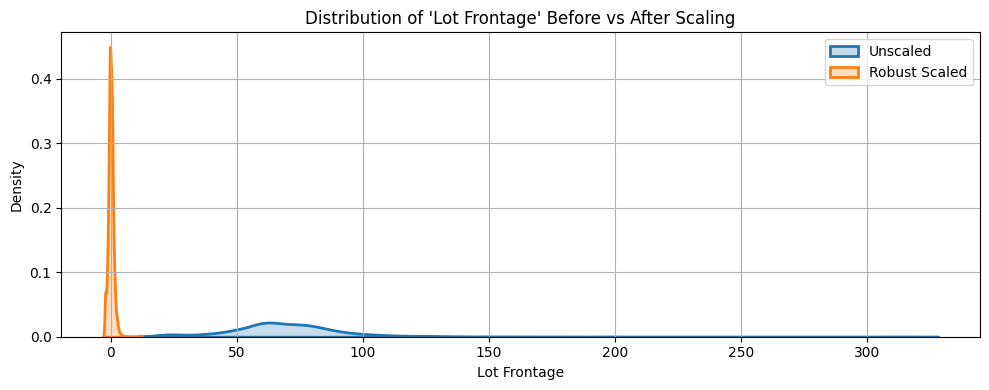

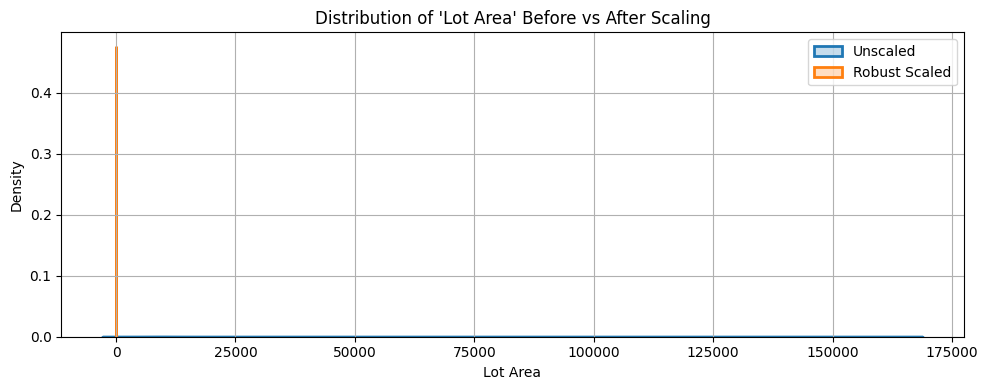

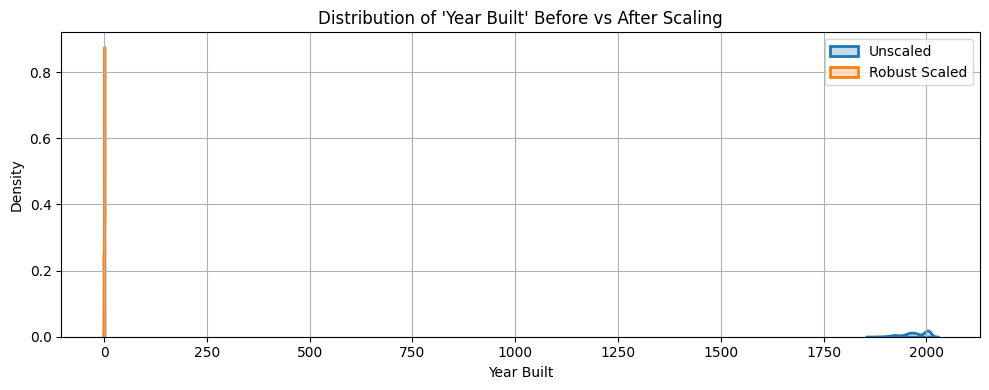

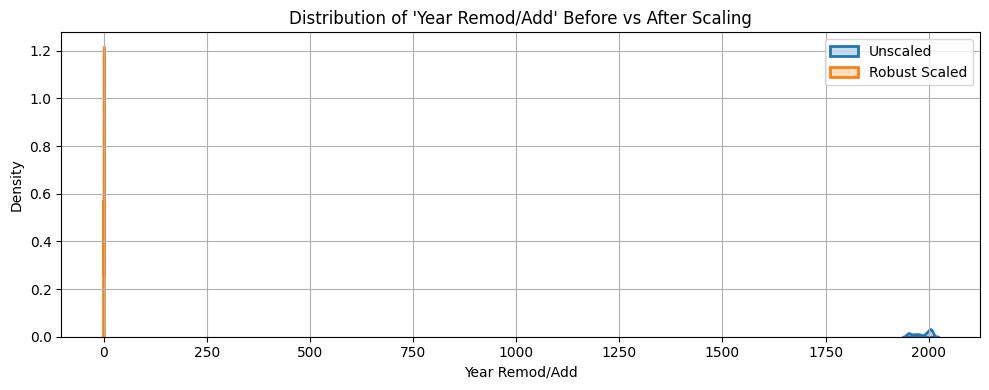

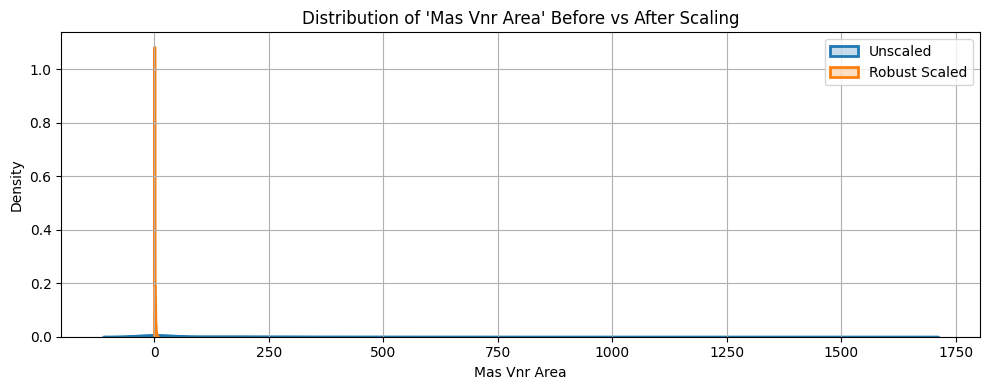

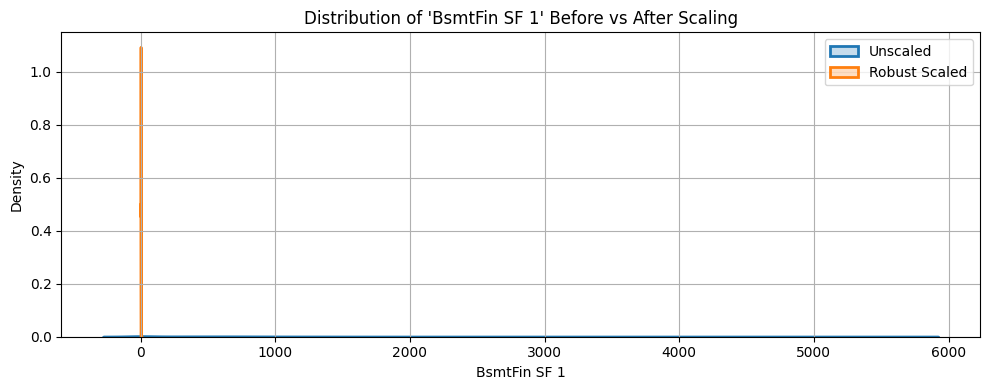

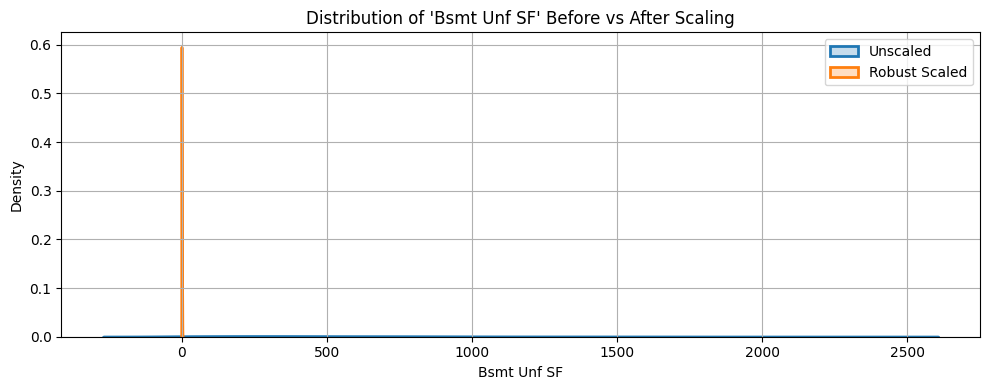

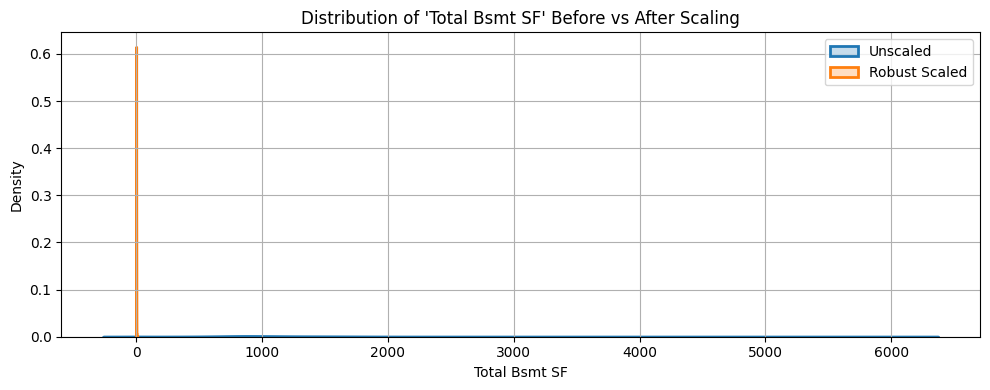

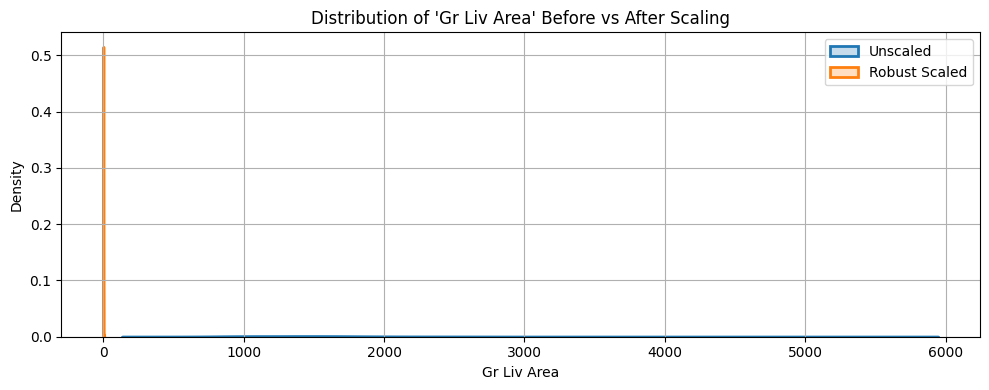

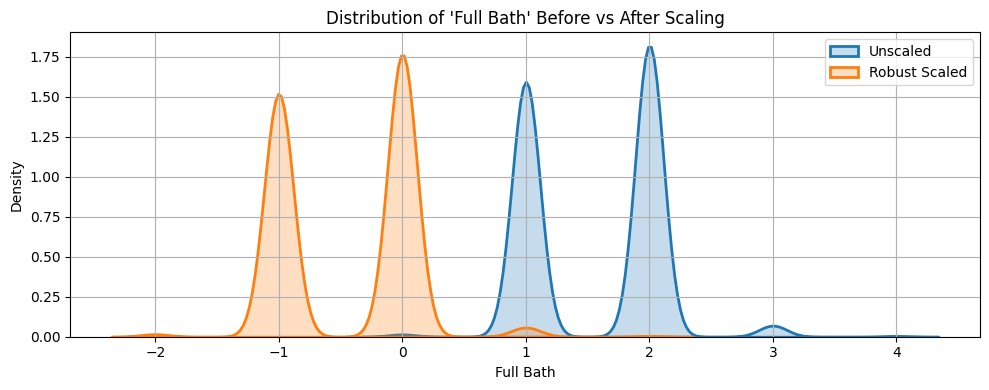

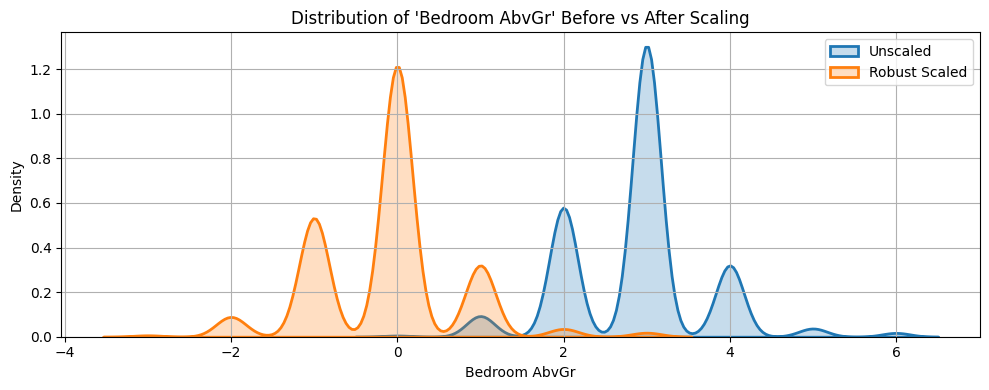

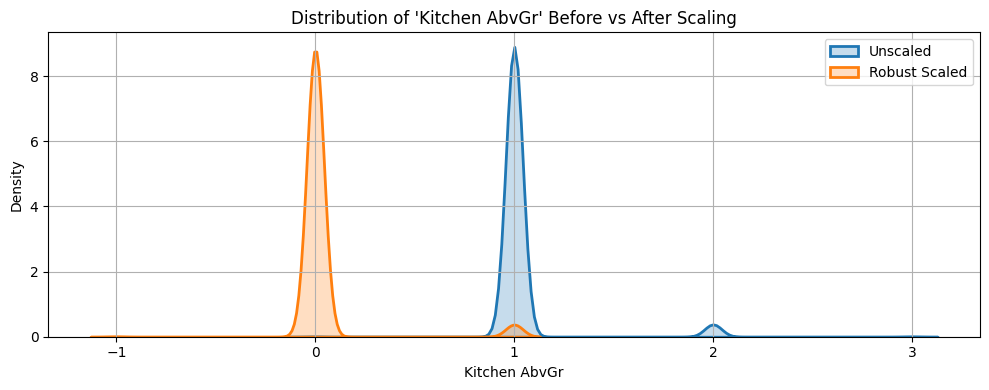

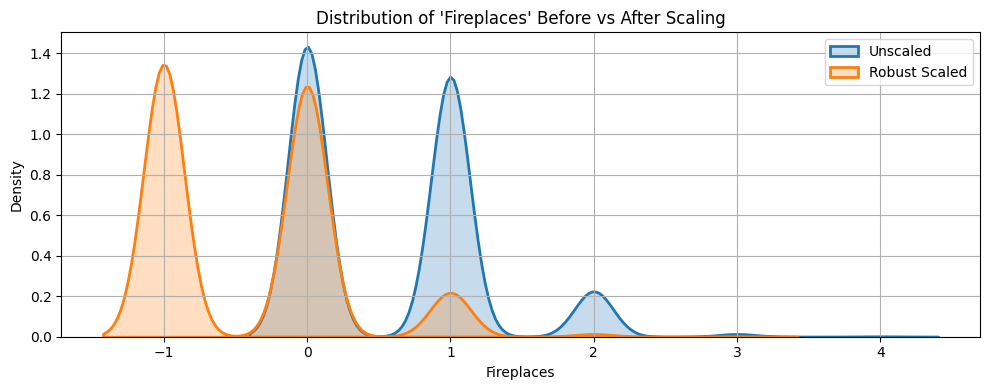

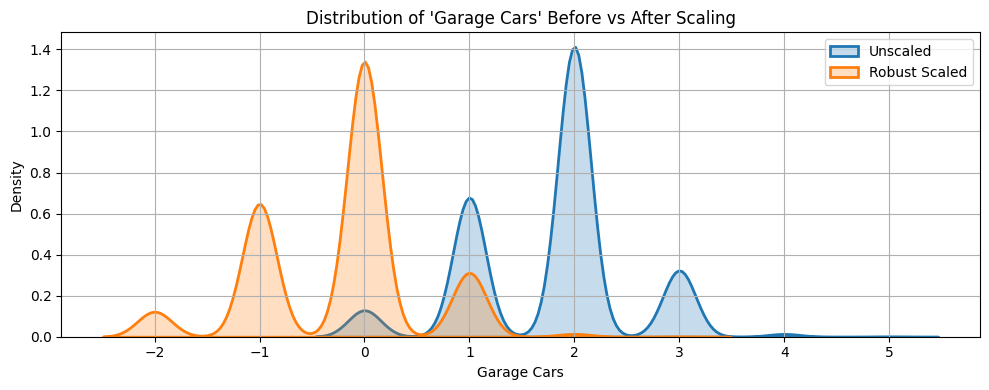

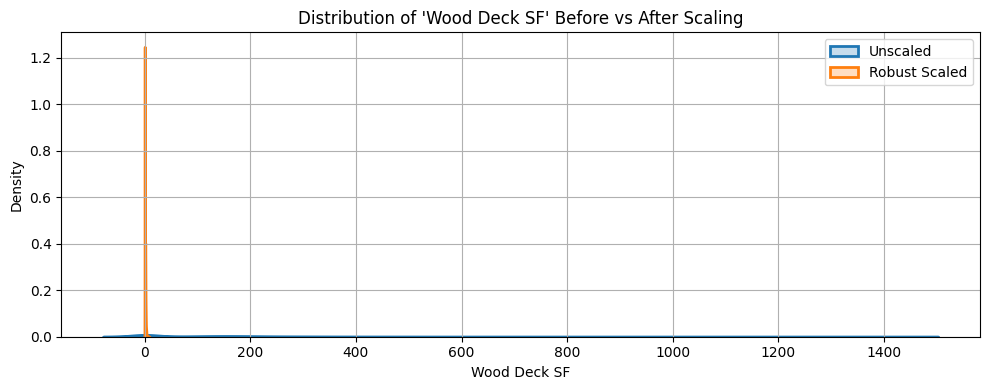

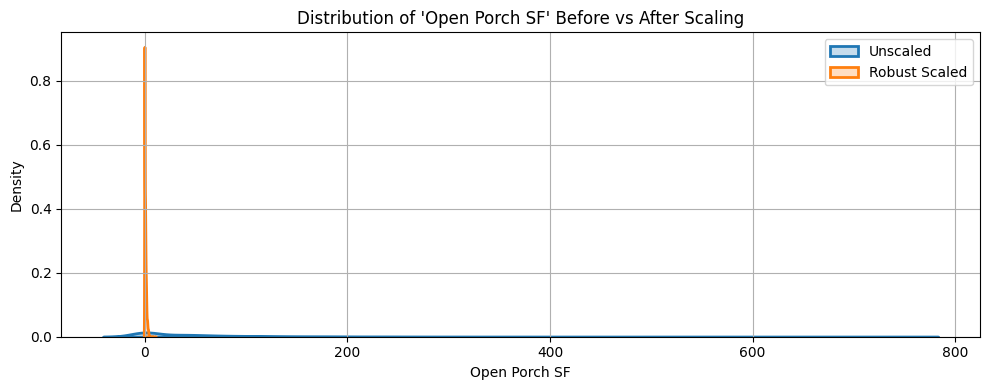

In [48]:
# Make features_to_plot as list of column names
features_to_plot = X.columns

# Copy unscaled data
X_unscaled = X.copy()

# Convert scaled array back to DataFrame
X_scaled = pd.DataFrame(X_train_scaled_array, columns=features_to_plot)

# Plot
for col in features_to_plot:
    plt.figure(figsize=(10, 4))
    sns.kdeplot(X_unscaled[col], label='Unscaled', fill=True, linewidth=2)
    sns.kdeplot(X_scaled[col], label='Robust Scaled', fill=True, linewidth=2)
    plt.title(f"Distribution of '{col}' Before vs After Scaling")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### Compare RMSPE for models applied to numeric series

In [49]:
# Make RMSPE scorer
from sklearn.metrics import make_scorer

def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

rmspe_scorer = make_scorer(rmspe, greater_is_better=False)


In [50]:
# Impute NaN values and make recommended models

from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Pipelines with imputer + scaler + model
models = {
    'Linear': make_pipeline(SimpleImputer(strategy='median'), RobustScaler(), LinearRegression()),
    'Ridge': make_pipeline(SimpleImputer(strategy='median'), RobustScaler(), Ridge(alpha=1.0)),
    'Lasso': make_pipeline(SimpleImputer(strategy='median'), RobustScaler(), Lasso(alpha=0.01, max_iter=10000))
}


In [51]:
# Cross-validation

from sklearn.model_selection import cross_val_score

results = {}

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, scoring=rmspe_scorer, cv=5)
    results[name] = -scores.mean()

# Results
for model_name, score in results.items():
  print(f"{model_name}: Mean RMSPE (CV=5) = {score:.5f}")


Linear: Mean RMSPE (CV=5) = 0.23721
Ridge: Mean RMSPE (CV=5) = 0.23716
Lasso: Mean RMSPE (CV=5) = 0.23721


In [52]:
# Isolate Ridge model

ridge_model = make_pipeline(
    SimpleImputer(strategy='median'),
    RobustScaler(),
    Ridge(alpha=1.0)
)

ridge_model.fit(X_train, y_train)


Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('robustscaler', RobustScaler()), ('ridge', Ridge())])

In [53]:
# Inspect predictive features

from sklearn.linear_model import Ridge

# Access the trained Ridge model inside the pipeline
ridge_regressor = ridge_model.named_steps['ridge']

# Extract the coefficients
ridge_coefs = pd.Series(ridge_regressor.coef_, index=X_train.columns)

# Sort by absolute value
ridge_coefs_sorted = ridge_coefs.reindex(ridge_coefs.abs().sort_values(ascending=False).index)

# Show top features
print(ridge_coefs_sorted.head(15))


Gr Liv Area       39657.739991
Kitchen AbvGr    -31986.039191
Year Remod/Add    22392.838667
Total Bsmt SF     16676.110352
Garage Cars       15970.756893
Year Built        15250.789932
BsmtFin SF 1       9048.010957
Fireplaces         8645.172165
Mas Vnr Area       7243.123004
Bedroom AbvGr     -6959.558997
Wood Deck SF       4148.185307
Bsmt Unf SF       -1925.523373
Full Bath          1543.010187
Lot Frontage       1531.819075
Open Porch SF       319.325274
dtype: float64


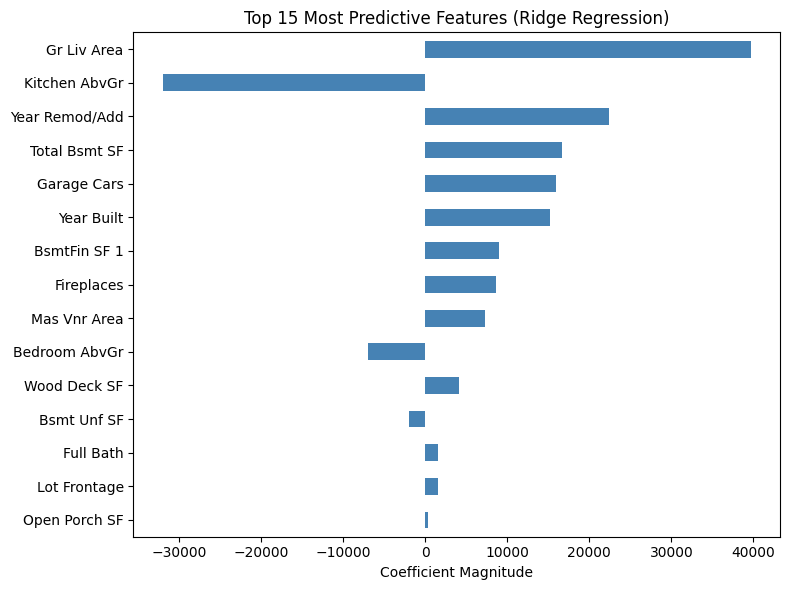

In [54]:
# Plot predictive features

plt.figure(figsize=(8,6))
ridge_coefs_sorted.head(15).plot(kind='barh', color='steelblue')
plt.gca().invert_yaxis()  # largest at top
plt.title("Top 15 Most Predictive Features (Ridge Regression)")
plt.xlabel("Coefficient Magnitude")
plt.tight_layout()
plt.show()


### Test best prediction model (lowest Mean RMSPE)

In [55]:
# Test prediction model

# Choose best model from cross-validation
final_model = models['Ridge']

# Fit on the entire training set
final_model.fit(X_train, y_train)

# Predict on the test data (scaling & imputation handled inside pipeline)
y_pred = final_model.predict(X_test)
y_pred #predicted sales prices


array([191732.95094905, 155282.37916417, 286554.2053359 ,  86333.07975327,
       262757.82279198, 262983.28303516, 260853.17079945, 202903.99842555,
       171331.32337621, 212462.36842494, 119940.71378928,  98453.42262872,
       147018.61423285, 203926.73873518, 200807.43776424, 255956.07748878,
        98548.69257995, 250165.74103946, 110086.84405794,  76775.34416267,
       255582.87699988, 170081.11097555, 213955.87671441, 173500.63186153,
       210754.47732344,  94557.25378239, 137111.98468701, 216420.09999817,
        73214.1147977 , 200557.83472577, 186376.53456412, 224831.27546625,
       182003.04789925, 141469.51216237, 122722.40298444, 202057.50936555,
       113175.83318324, 214082.100829  , 119115.99186737, 109112.83037692,
       212233.64423649,  42209.41916021, 165991.2452308 , 119357.12070308,
       126972.19603012, 243216.88609625, 258212.01079733, 173346.8773542 ,
        94415.24582333, 189501.06310312,  71971.00005993, 279196.60415825,
       156043.55449256, 2

## Data Visualization/Communication of Results


In [56]:
# Compare actual and predicted sales prices

comparison_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred
})

print(comparison_df.head(15))


    Actual      Predicted
0   186000  191732.950949
1   157500  155282.379164
2   277500  286554.205336
3    96500   86333.079753
4   322400  262757.822792
5   267916  262983.283035
6   245000  260853.170799
7   185000  202903.998426
8   205000  171331.323376
9   211000  212462.368425
10  139000  119940.713789
11  120000   98453.422629
12  150000  147018.614233
13  195500  203926.738735
14  194000  200807.437764


In [57]:
# Get mean RMSPE for test data set

def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

test_rmspe = rmspe(y_test, y_pred)
print(f"Test data mean RMSPE (CV=5): {test_rmspe:.5f}")


Test data mean RMSPE (CV=5): 0.35071


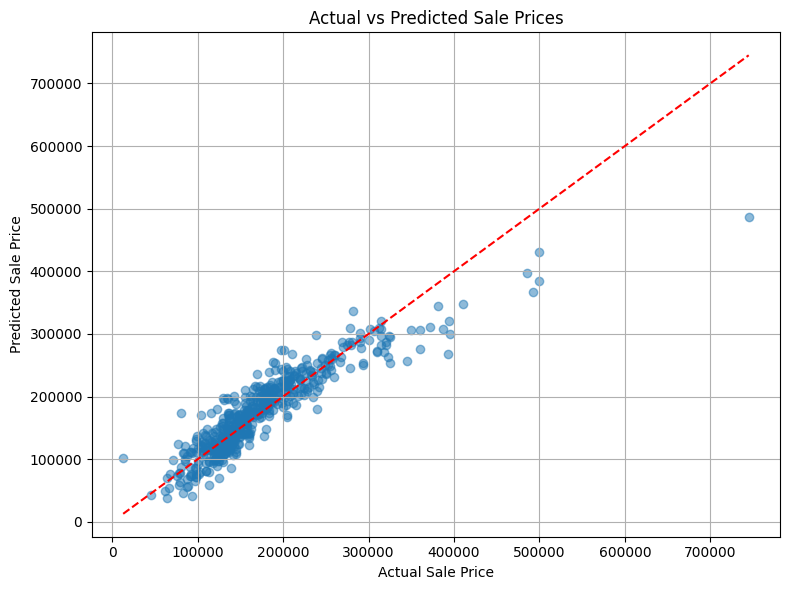

In [58]:
# Plot actual vs predicted prices for test data set

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # prediction line
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Actual vs Predicted Sale Prices')
plt.grid(True)
plt.tight_layout()
plt.show()


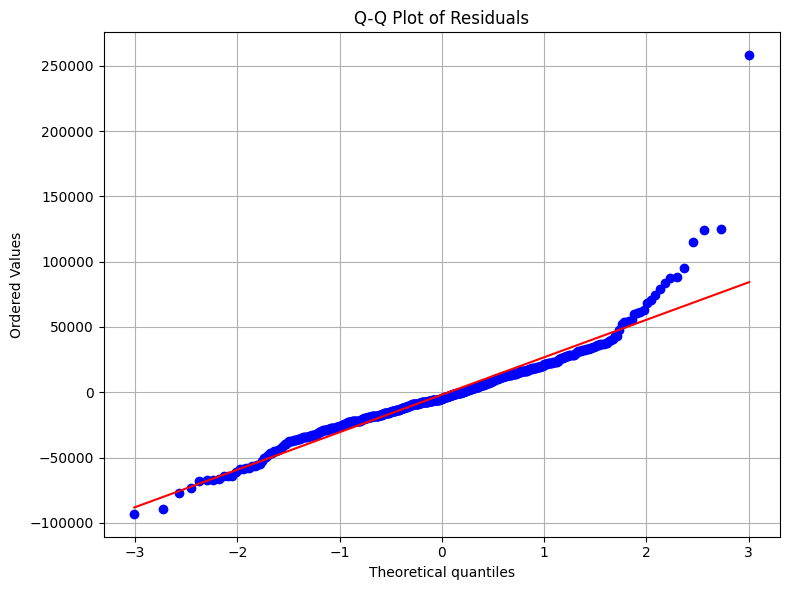

In [59]:
import scipy.stats as stats

# Compute residuals
residuals = y_test - y_pred

# Q-Q plot
plt.figure(figsize=(8,6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()


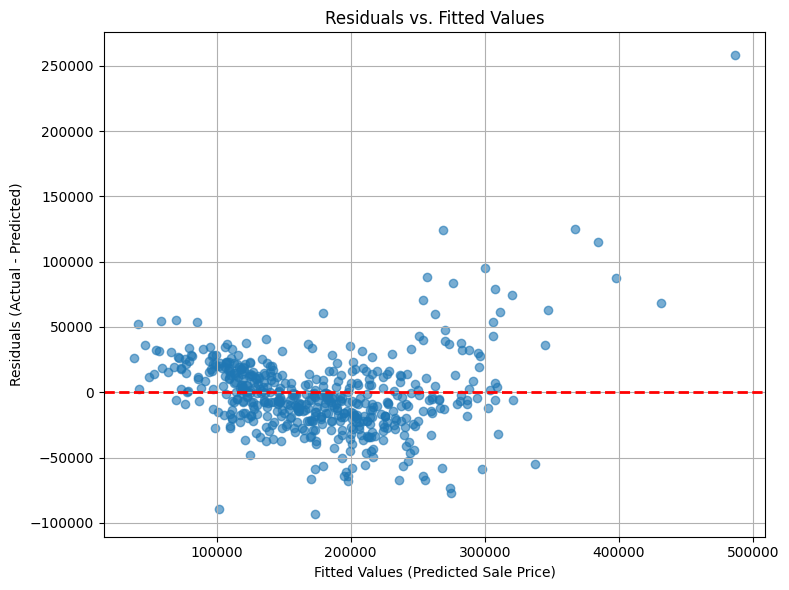

In [60]:
# Residuals and fitted values

residuals = y_test - y_pred
fitted = y_pred

# Plot
plt.figure(figsize=(8,6))
plt.scatter(fitted, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Fitted Values (Predicted Sale Price)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs. Fitted Values")
plt.grid(True)
plt.tight_layout()
plt.show()


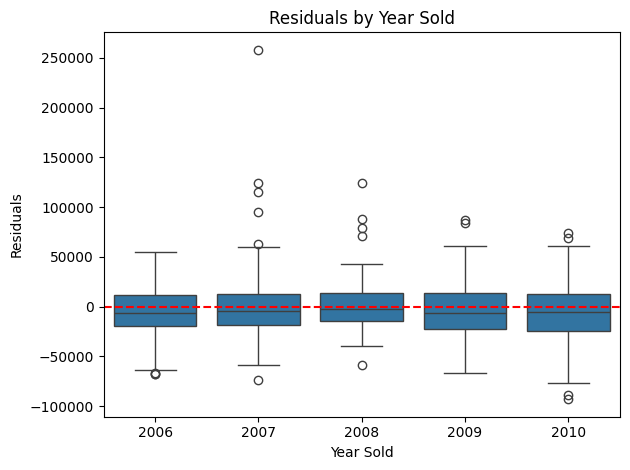

In [61]:
# Boxplot of residuals vs. year sold

x = housing_df_lowNaN['Yr Sold']

sns.boxplot(x=x, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals by Year Sold")
plt.xlabel("Year Sold")
plt.ylabel("Residuals")
plt.tight_layout()
plt.show()


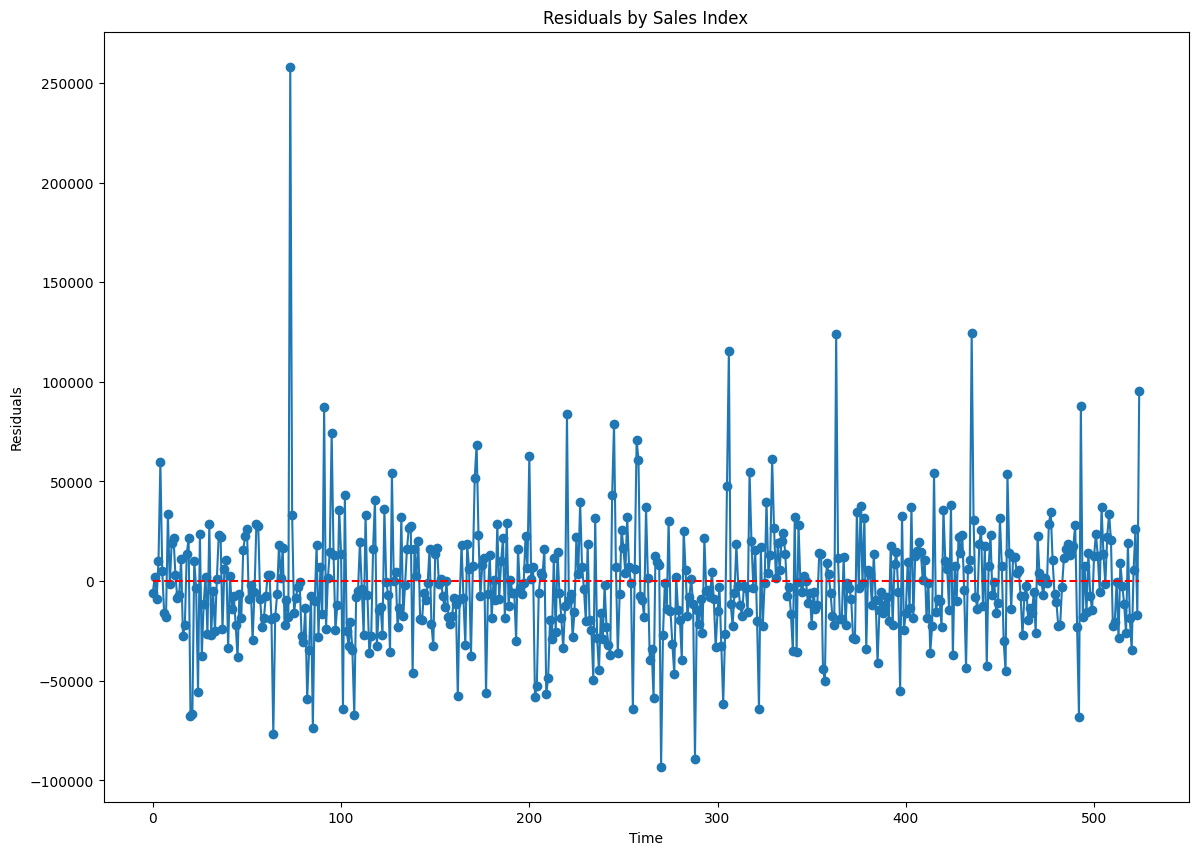

In [62]:
# Residuals vs sales index - shows feature indepedence

res = residuals

plt.figure(figsize = (14,10))
plt.scatter(range(len(res)), res)
plt.plot(range(len(res)), res)
plt.title("Residuals by Sales Index")
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.hlines(0, min(range(len(res))), max(range(len(res))), colors = 'red', linestyles = 'dashed') ;
